# Clustering

In [1]:
import pandas as pd
import nltk
import re

df = pd.read_csv("final_orig.csv", 
                 sep = '\t')

df['Text'] = df['Text'].str.lower()
sentenses_list = df['Text'].tolist()

In [2]:
df.head()

,Reddit ID,Fake ID,Title,Nickname,Text,Text_len
0,%% 7nbwy8,0,%% How to get through to people that you can b...,%% Ralyt,i've been on and off depression for my entire ...,867
1,%% 7nbwwv,1,%% Ever wonder how long it would be until some...,%% SyIentButDeadly,just a thought i have sometimes. i'm not getti...,209
2,%% 7nbw09,2,%% Dear 2017,%% lolitsjesus808,i loved you at the beginning 2017. you took me...,507
3,%% 7nbvyp,3,%% I'm so lost...,%% nxx10,i just want to be myself again.i am full of an...,329
4,%% 7nbvo4,4,%% Days aren't even days anymore. Just dayligh...,%% Weiser17,"every ""day"" is the fucking same. wake up, show...",222


In [3]:
#this function generated .json file for labelStudio. 20 000 texts were selected.
# import json

# def text2json(sentences):
#     sentences_dict = []
#     for s in sentences:
#         sentences_dict.append({'text': s})
#     with open('texts.json', 'w') as outfile:
#         json.dump(sentences_dict, outfile)

#text2json(sentenses_list[:20000]) #were exported for annotation

# doc2vec

- corpus - all the texts/ dataset;
- document - each text;
- token - each word;

In [4]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import multiprocessing
#nltk.download('punkt')

In [6]:
import contractions
import re 
import string

#Expanding Contractions
df['content_cleaned'] = df['Text'].apply(lambda row: contractions.fix(row))

# function to remove punctuation
def remove_punctuation(string):
    return re.sub(r'[^\w\s]','', string)

df['content_cleaned'] = df['content_cleaned'].apply(remove_punctuation)

In [11]:
#transferring corpus to list
clustering_texts = df['content_cleaned'].str.lower().tolist()

In [40]:
from nltk.tokenize import word_tokenize
import random

#split into tokens
tokenized = []
for doc in random.sample(clustering_texts, 20000):
    tokenized.append(word_tokenize(doc))
    
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

newStopWords = ['ya', 'ur', 'coz', 'am', 'okay', 'hey', 'hiyo', 'hallo', 'inn', 'hae', 'bro', 
                'iam', 'pliz', 'brother', 'plz', 'ama', 'ok', 'okey' 'hi', 'please', 'plz', 'hii']
stop_words.extend(newStopWords)
stop_words_2 = set(stop_words)

exclude_words = set(("not")) 
#                      "between", "into", "through", "during",
#                      "before", "after", "about", "against", 
#                      "above", "below", "to", "from", 'not'
#                      "up", "down", "in", "out", "on", "how"
#                      "off", "over", "under", "where", "here", "no"))
new_stop_words = stop_words_2#.difference(exclude_words)

In [41]:
tokenized_sw = []

for i, row in enumerate(tokenized):
    temp_sent = []
    for word in row:
        if word not in new_stop_words:
            temp_w = re.sub("\d+", "", word)
            temp_sent.append(temp_w)
    str_list = list(filter(None, temp_sent))
    tokenized_sw.append(str_list)
    
tokenized_sw_cleaned = [x for x in tokenized_sw if x != []]

In [42]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_sw_cleaned, scoring = 'npmi', threshold = 0.0)
trigram = gensim.models.Phrases(bigram[tokenized_sw_cleaned])  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example print(trigram_mod[bigram_mod[tokenized_sw_cleaned[99]]])

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [43]:
# Form Bigrams
data_words_bigrams = make_bigrams(tokenized_sw_cleaned)

# Form 3grams
data_words_3grams = make_trigrams(data_words_bigrams)

In [45]:
texts_2 = []

for i, row in enumerate(data_words_3grams):
    temp_sent = []
    for word in row:
        if len(word) >= 2:
            temp_sent.append(word)
    texts_2.append(temp_sent)

In [46]:
# tokenized_texts = []
# for i in sentenses_list[:15000]:
#     tokenized_texts.append(word_tokenize(i)) #tokinize

tagged_tok_texts = [TaggedDocument(d, [i]) for i, 
                   d in enumerate(texts_2)]

In [6]:
# pattern_to_delete = re.compile(r'\b[a-zA-Z]{3,}\b')
#stop_words = set(stopwords.words('english'))
# for s in range(len(tokenized_texts[:100])):
#     for w in range(len(tokenized_texts[s])):
#         #print(tokenized_texts[s][w])
#         tokenized_texts[s][w] = re.sub(pattern_to_delete, '', tokenized_texts[s][w]) 
#     tokenized_texts[s] = [w for w in tokenized_texts[s] if w!= '']
#     tokenized_texts[s] = [w for w in tokenized_texts[s] if not w in stop_words]
# tagged_tok_texts = [TaggedDocument(d, [i]) for i, 
#                    d in enumerate(tokenized_texts)]

dm - Defines the training algorithm. If dm=1, ‘distributed memory’ (PV-DM) is used. Otherwise, distributed bag of words (PV-DBOW) is employed.

In [48]:
cores = multiprocessing.cpu_count()
#02:09 - 02.15

model_d2v_dm = Doc2Vec(tagged_tok_texts, 
                vector_size = 200, 
                window = 5, #The maximum distance between the current and predicted word within a sentence. 
                workers = cores,
                epochs = 50,
                dm = 1)

In [ ]:
model_d2v_DBOW = Doc2Vec(tagged_tok_texts, 
                vector_size = 200, 
                window = 5, #The maximum distance between the current and predicted word within a sentence. 
                workers = cores,
                epochs = 50,
                dm = 0)

In [8]:
# Save trained doc2vec model
model_d2v_dm.save("test_doc2vec_dm.model")
model_d2v_DBOW.save("test_doc2vec_DBOW.model")
#Load saved model: model = Doc2Vec.load("test_doc2vec_dm.model")

## Elbow, Silhouette coofieicent, Davies Bouldin score


In [52]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.cluster import Birch

In [10]:
model_d2v_dm = Doc2Vec.load("test_doc2vec_dm.model")
model_d2v_DBOW = Doc2Vec.load("test_doc2vec_DBOW.model")

In [11]:
def find_optimal_N_clusters_Kmeans(model_DM, model_DBOW, max_k):
    #creating lists for model PV-DM
    elbow_scores_model_DM = []
    silhouette_coofieicents_model_DM = []
    db_scores_model_DM = []
    
    #creating lists for model PV-DBOW
    elbow_scores_model_DBOW = []
    silhouette_coofieicents_model_DBOW = []
    db_scores_model_DBOW = []
    
    num_of_clusters = range(2, max_k + 1, 2)
    for k in num_of_clusters: 
        k_means_model_DM = KMeans(n_clusters = k, 
                               max_iter = 2000,
                               init = 'k-means++',
                               random_state = 142).fit(model_DM.docvecs.vectors_docs)
        pred_clust_index_DM = k_means_model_DM.predict(model_DM.docvecs.vectors_docs)
        
        k_means_model_DBOW = KMeans(n_clusters = k, 
                               max_iter = 2000,
                               init = 'k-means++',
                               random_state = 142).fit(model_DBOW.docvecs.vectors_docs)
        pred_clust_index_DBOW = k_means_model_DBOW.predict(model_DBOW.docvecs.vectors_docs)
    
        elbow_scores_model_DM.append(k_means_model_DM.inertia_)
        elbow_scores_model_DBOW.append(k_means_model_DBOW.inertia_)
    
        silhouette_coofieicents_model_DM.append(silhouette_score(model_DM.docvecs.vectors_docs, 
                                                                 pred_clust_index_DM))
        silhouette_coofieicents_model_DBOW.append(silhouette_score(model_DBOW.docvecs.vectors_docs, 
                                                                   pred_clust_index_DBOW))
    
        db_scores_model_DM.append(davies_bouldin_score(model_DM.docvecs.vectors_docs, pred_clust_index_DM))
        db_scores_model_DBOW.append(davies_bouldin_score(model_DBOW.docvecs.vectors_docs, pred_clust_index_DBOW))
    
    f, ax = plt.subplots(4, 1, figsize = (10, 16))
    
    ax[0].plot(num_of_clusters, elbow_scores_model_DBOW, marker='H', label = "Distributed Bag of Words (PV-DBOW)",
              color = "orange")
    ax[0].legend()
    ax[0].set_xticks(num_of_clusters)
    ax[0].set_xticklabels(num_of_clusters)
    ax[0].set_ylabel('Error Sum of Squares (SSE)', fontsize = 16)
    ax[0].set_title('(a.1) Elbow method for doc2vec: PV-DBOW', fontsize = 20)
    
    ax[1].plot(num_of_clusters, elbow_scores_model_DM, marker='D', label = "Distributed Memory (PV-DM)",
              color = "dodgerblue")
    ax[1].legend(fancybox = True, shadow = True)
    ax[1].set_xticks(num_of_clusters)
    ax[1].set_xticklabels(num_of_clusters)
    ax[1].set_ylabel('Error Sum of Squares (SSE)', fontsize = 16)
    ax[1].set_title('(a.2) Elbow method for doc2vec: PV-DM', fontsize = 20)
    
    ax[2].plot(num_of_clusters, silhouette_coofieicents_model_DM, marker='D', 
               label = "Distributed Memory (PV-DM)", color = "dodgerblue")
    ax[2].plot(num_of_clusters, silhouette_coofieicents_model_DBOW, marker='H', 
               label = "Distributed Bag of Words (PV-DBOW)", color = "orange")
    ax[2].legend(fancybox = True, shadow = True)
    ax[2].set_xticks(num_of_clusters)
    ax[2].set_xticklabels(num_of_clusters)
    ax[2].set_ylabel('Silhouette coofieicent', fontsize = 16)
    ax[2].set_title('(b) Silhouette method', fontsize = 20)
    
    ax[3].plot(num_of_clusters, db_scores_model_DM, marker='D', label = "Distributed Memory (PV-DM)", 
              color = "dodgerblue")
    ax[3].plot(num_of_clusters, db_scores_model_DBOW, marker='H', label = "Distributed Bag of Words (PV-DBOW)",
              color = "orange")
    ax[3].legend(fancybox = True, shadow = True)
    ax[3].set_xlabel('Number of clusters', fontsize = 16)
    ax[3].set_xticks(num_of_clusters)
    ax[3].set_xticklabels(num_of_clusters)
    ax[3].set_ylabel('Davies Bouldin score', fontsize = 16)
    ax[3].set_title('(c) Davies Bouldin method', fontsize = 20)

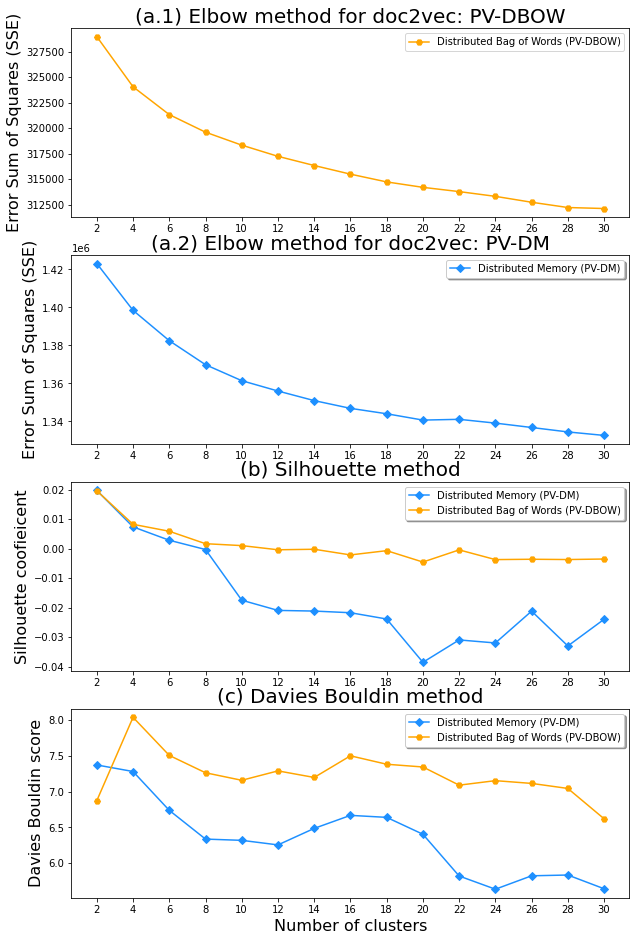

In [12]:
#14:09 - 14.12
find_optimal_N_clusters_Kmeans(model_d2v_dm, model_d2v_DBOW, 30)

## doc2vec clustering

In [53]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
import matplotlib.pyplot as plt
import mpl_toolkits
import seaborn as sns

In [54]:
def k_means_clustering(model, num_of_clusters, ran_st):
    k_value = num_of_clusters
    
    k_means_model = KMeans(n_clusters = k_value, 
                           init = 'k-means++',
                           max_iter = 2000,
                           random_state = ran_st)  
    k_means_model.fit(model.docvecs.vectors_docs)

    labels = k_means_model.labels_.tolist()
    clusters = k_means_model.fit_predict(model.docvecs.vectors_docs)
    
    return labels, clusters

In [72]:
#1 minute model_d2v_dm, model_d2v_DBOW,
labels_DM, clusters_DM = k_means_clustering(model_d2v_dm, 2, 142)
labels_DBOW, clusters_DBOW = k_means_clustering(model_d2v_DBOW, 2, 142)

In [16]:
# def print_numbers(ax):
#     for rect in ax.patches:
#         height = rect.get_height()
#         ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
#                 xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')
    
# f, ax = plt.subplots(1, 1, figsize = (17, 10))

# ax.hist([labels_DM, labels_DBOW], color = ["#F46197", "#F8E16C"],
#         label = ["Distributed Memory (PV-DM)", "Distributed Bag of Words (PV-DBOW)"], ec = 'k')
# ax.legend(fontsize = 11, fancybox = True, shadow = True)
# ax.set_title('Number of text in each cluster: DM vs. DBOW', fontsize = 16)
# ax.set_ylabel('Number of texts', fontsize = 14)
# #ax.set_xticklabels()
# ax.set_xlabel('Clusters', fontsize = 14)
# ax.grid(axis = 'y', alpha = 0.75)

# print_numbers(ax)

In [17]:
#legend for clustering - https://stackoverflow.com/questions/44493417/pandas-dataframe-bar-plot-plot-bars-different-colors-from-specific-colormap

## 2D PCA Scatter Plot for clustering results


In [73]:
#2 dimensions
def plot_clusters_PCA(model, dimension, rand):
    pca = PCA(n_components = dimension, random_state = rand).fit(model.docvecs.vectors_docs)
    datapoint = pca.transform(model.docvecs.vectors_docs)
    
    return datapoint

datapoint_2D_DM = plot_clusters_PCA(model_d2v_dm, 2, 142)
datapoint_2D_DBOW = plot_clusters_PCA(model_d2v_DBOW, 2, 142)

datapoint_3D_DM = plot_clusters_PCA(model_d2v_dm, 2, 142)
datapoint_3D_DBOW = plot_clusters_PCA(model_d2v_DBOW, 2, 142)

Text(0.5, 1.0, '(b) Distributed Bag of Words (PV-DBOW)')

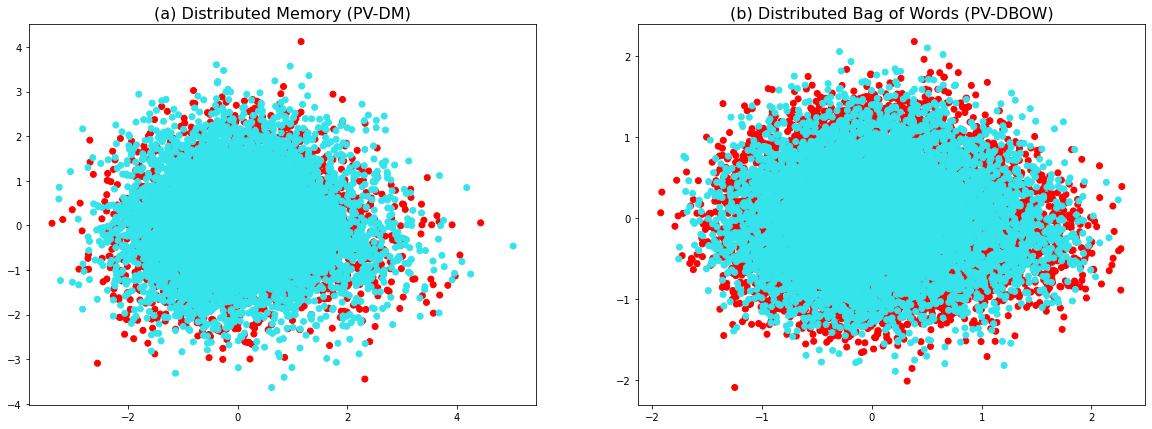

In [74]:
f, ax = plt.subplots(1, 2, figsize = (20, 7))

label_colors = [
          #"#ffe946", #Corn
          #"#008080", #Teal, dark green
          #"#9ac1ff", #baby blue eyes
            "#FF0000", #deep red
            "#34E4EA"] #fluorecent blue
          #"#ff4e78", #Brink pink
          #"#511180", #Blue violate colour wheel
         # "#A44200", #Rust
          #"#edf694"  #Key lime

labels_DM.sort()
labels_DBOW.sort()

targets = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

color_DM = [label_colors[i] for i in labels_DM]
color_DBOW = [label_colors[i] for i in labels_DBOW]

ax[0].scatter(datapoint_2D_DM[:, 0], datapoint_2D_DM[:, 1], c = color_DM)
ax[0].set_title('(a) Distributed Memory (PV-DM)', fontsize = 16)

ax[1].scatter(datapoint_2D_DBOW[:, 0], datapoint_2D_DBOW[:, 1], c = color_DBOW)
ax[1].set_title('(b) Distributed Bag of Words (PV-DBOW)', fontsize = 16)

## 3D PCA Scatter Plot for clustering results


Text(0.5, 0.92, '(b) Distributed Memory (PV-DBOW)')

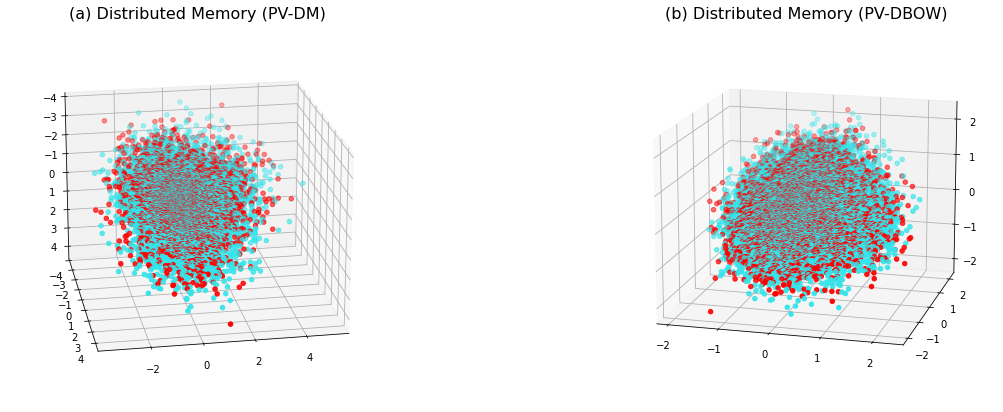

In [75]:
fig = plt.figure(figsize=(20,7))

ax = fig.add_subplot(1, 2, 1, projection='3d', azim = 280, elev = 200)
ax.scatter(datapoint_3D_DM[:, 0], datapoint_3D_DM[:, 1],datapoint_3D_DM[:, 1], c = color_DM)
ax.set_title('(a) Distributed Memory (PV-DM)', fontsize = 16)

ax = fig.add_subplot(1, 2, 2, projection='3d', azim = 285, elev = 15)
ax.scatter(datapoint_3D_DBOW[:, 0], datapoint_3D_DBOW[:, 1],datapoint_3D_DBOW[:, 1], c = color_DM)
ax.set_title('(b) Distributed Memory (PV-DBOW)', fontsize = 16)

## 2D tSNE Scatter Plot for clustering results

In [59]:
#2 dimensions 02.25 - 14.23
def plot_clusters_tSNE(model, dimension, rand):
    tSNE = TSNE(n_components = dimension, random_state = rand)
    datap = tSNE.fit_transform(model.docvecs.vectors_docs)
    
    return datap

datap_2D_DM = plot_clusters_tSNE(model_d2v_dm, 2, 142)
datap_2D_DBOW = plot_clusters_tSNE(model_d2v_DBOW, 2, 142)

Text(0.5, 1.0, '(b) Distributed Bag of Words (PV-DBOW)')

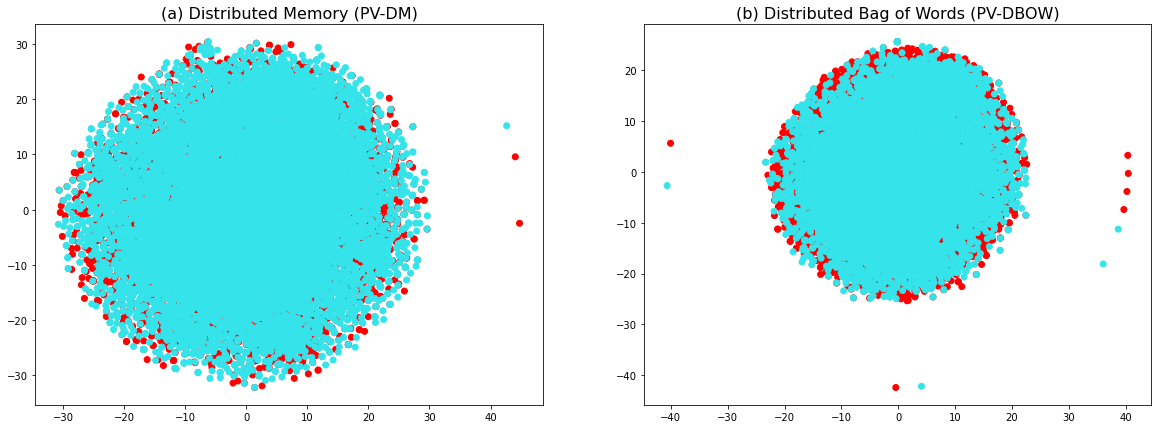

In [60]:
f, ax = plt.subplots(1, 2, figsize = (20, 7))

labels_DM.sort()
labels_DBOW.sort()

targets = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

color_DM = [label_colors[i] for i in labels_DM]
color_DBOW = [label_colors[i] for i in labels_DBOW]

ax[0].scatter(datap_2D_DM[:, 0], datap_2D_DM[:, 1], c = color_DM)
ax[0].set_title('(a) Distributed Memory (PV-DM)', fontsize = 16)

ax[1].scatter(datap_2D_DBOW[:, 0], datap_2D_DBOW[:, 1], c = color_DBOW)
ax[1].set_title('(b) Distributed Bag of Words (PV-DBOW)', fontsize = 16)

## 3D tSNE Scatter Plot for clustering results

In [23]:

# datap_3D_DM = plot_clusters_tSNE(model_d2v_dm, 3, 142)
# datap_3D_DBOW = plot_clusters_tSNE(model_d2v_DBOW, 3, 142)

In [24]:
# fig = plt.figure(figsize=(20,7))

# ax = fig.add_subplot(1, 2, 1, projection='3d')
# ax.scatter(datap_3D_DM[:, 0], datap_3D_DM[:, 1],datap_3D_DM[:, 1], c = color_DM)
# ax.set_title('(a) Distributed Memory (PV-DM)', fontsize = 16)
# ax.legend(set(labels_DM), fancybox=True, shadow=True)

# ax = fig.add_subplot(1, 2, 2, projection='3d')
# ax.scatter(datap_3D_DBOW[:, 0], datap_3D_DBOW[:, 1],datap_3D_DBOW[:, 1], c = color_DM)
# ax.set_title('(b) Distributed Memory (PV-DBOW)', fontsize = 16)
# ax.legend(set(labels_DM), fancybox=True, shadow=True)